# Linear Probe Experiments
A first try at generating data in a procgen maze environment, and using that to construct a linear probe to detect a "cheese signal" in the neural network layers of a pre-trained RL agent. 

## Initialize Environment 

In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from procgen import ProcgenGym3Env
from procgen_tools import maze
from procgen_tools.models import load_policy
from procgen_tools import maze as maze_api

In [2]:

from pathlib import Path
import io

save_dir = Path("maze_linear_probe_data")
if not save_dir.is_dir():
    os.mkdir(save_dir)

The gym environment will be created through `procgen-tools`. It provides a wrapper around the original procgen environment to make it compatible with gym. 

In [3]:
seed = 42
wrapped_venv = maze_api.create_venv(
    num=1, start_level=int(seed), num_levels=0, num_threads = 4
)
wrapped_venv.env.get_info()[0].keys()

dict_keys(['prev_level_seed', 'prev_level_complete', 'level_seed', 'rgb'])

In [4]:
# Get the procgen env directly like so
wrapped_venv.env

<CEnv lib_path=/home/gearspark/Projects/ai-safety-camp-2024-model-agents/venv/lib/python3.10/site-packages/procgen/data/prebuilt/libenv.so options={'center_agent': True, 'use_generated_assets': False, 'use_monochrome_assets': False, 'restrict_themes': False, 'use_backgrounds': True, 'paint_vel_info': False, 'distribution_mode': 1, 'env_name': 'maze', 'num_levels': 0, 'start_level': 4242, 'num_actions': 15, 'use_sequential_levels': False, 'debug_mode': 0, 'rand_seed': 513946915, 'num_threads': 4, 'render_human': True, 'resource_root': '/home/gearspark/Projects/ai-safety-camp-2024-model-agents/venv/lib/python3.10/site-packages/procgen/data/assets/'}>

## Load Agent
Download one of the agents from the [trained model files](https://drive.google.com/drive/folders/1Ig7bzRlieyYFcdKL_PM-guSWR8WryDOL). I used `maze_I/model_rand_region_5` without knowing about the performance of this agent. Do not forget to rename the model file or change the filename below.

In [5]:
policy = load_policy('model_rand_region_15.pth', action_size=15, device=torch.device('cpu'))

## Run Episodes

In [6]:

def run_episode(model, maze_environment,logger, argmax=True, max_time_steps=256):
    model.eval()  # Switch off gradient tracking and other training time mechanisms
    obs = maze_environment.reset()
    logger.update_environment(maze_environment) 
    for step in range(max_time_steps):
        out, _ = model(torch.FloatTensor(obs))
        act = out.probs.argmax(dim=-1).numpy() if argmax else out.sample().numpy()
        obs, rew, done, info = maze_environment.step(act)
        logger.log(model, step, act, obs, rew, done)  # Updated call
        if done:
            break
    on_done()


In [7]:
# Run a test episode
run_episode(policy, wrapped_venv)

In [8]:
# Define a custom logging function
class CustomLogger:

    def __init__(self):
        self.observations = []
        self.rewards = []

    def log(self, model, environment, step, act, obs, rew, done, info):
        self.observations.append(obs)
        self.rewards.append(float(rew[0]))

    def reset_logs(self):
        self.observations = []
        self.rewards = []

logger = CustomLogger()
run_episode(policy, wrapped_venv, on_step=logger.log)

In [9]:
obs = logger.observations
rews = logger.rewards
print(f"n obs: {len(obs)}, n rewards: {len(rews)}, total reward: {sum(rews)}")

n obs: 30, n rewards: 30, total reward: 10.0


## Logging Model Activations
Activations can be [logged with `circrl`](https://github.com/montemac/circrl/tree/main). The hook manager logs a single activation by default. Since we want to have activations spread over the entire eposide we will use a custom hook manager that can be reset between episodes.

In [10]:
def get_model_layer_names(model):
    return [name for name, module in model.named_modules()]

In [11]:
names = get_model_layer_names(policy)
print(names[:5])

['', 'embedder', 'embedder.block1', 'embedder.block1.conv', 'embedder.block1.maxpool']


Create a hook to log the activations of the corresponding layers.

In [12]:
from circrl import hooks

policy_hook = hooks.HookManager(
    model=policy,
    cache=names[1:4]
)

print("Before logging")
print(policy_hook.cache_results.keys())

# Run an environment update in the policy hook context to start logging
with policy_hook:
    obs = wrapped_venv.reset()
    output = policy(torch.FloatTensor(obs))

print("After logging")
print(output)
print(policy_hook.cache_results.keys())

Before logging
dict_keys([])
After logging
(Categorical(logits: torch.Size([1, 15])), tensor([8.3832], grad_fn=<ViewBackward0>))
dict_keys(['embedder.block1.conv', 'embedder.block1', 'embedder'])


Be careful! In the default log setting the `cache_results` gets overwritten every time the policy is run:

In [13]:
with policy_hook:
    obs = wrapped_venv.reset()
    output = policy(torch.FloatTensor(obs))

print("log size after a single execution:")
print(f"\t{policy_hook.cache_results[names[1]].size()}")

with policy_hook:    
    obs = wrapped_venv.reset()
    for _ in range(10):
        output = policy(torch.FloatTensor(obs))

print("Log size after a multiple executions:")
print(f"\t{policy_hook.cache_results[names[1]].size()}")

log size after a single execution:
	torch.Size([1, 256])
Log size after a multiple executions:
	torch.Size([1, 256])


## Gathering Training Data
To gather training data we need to run multiple episodes and store the activations of the model alongside the environment parameters. Procgen-tools provides some convenience functions to make this easier.

In [14]:
def generate_maze_training_data(model, n_episodes,logger, on_episode_step, on_episode_done ):
    max_seed = int(1e9)
    seeds = np.random.default_rng().choice(max_seed, size=n_episodes, replace=False)

    for seed in tqdm(seeds):
        wrapped_venv = maze_api.create_venv(
            num=1, start_level=int(seed), num_levels=0, num_threads = 4
        )  # Convenience functions

        run_episode(model, wrapped_venv, on_step=on_episode_step, on_done=on_episode_done)

In [15]:
generate_maze_training_data(policy, 1, dummy_step_log, dummy_done_log)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


We need a system to log activations and environment variables persistently. It would be best to avoid having to edit code related to model execution when logging to avoid introducting bugs. We can use something like the following logging setup to log episodic data to disk at the end of every episode. It combines the previous logging function with hooks:

In [16]:
import pickle

class ProbeDataLogger:
    def __init__(self, model, save_file_path=""):
        self._init_logs()

        self.model = model
        layer_names = get_model_layer_names(model)
        self.model_hook = hooks.HookManager(
            model=model,
            cache=names
        )
        save_file_path = Path(save_file_path)
        self._file_path = save_file_path
        self._file_extension = ".pkl"
        self._current_ep = 0
        self.env = None
    
    def update_environment(self, env):
        """Update the logger to use the current environment instance."""
        self.env = env

    def log(self, model, environment, step, act, obs, rew):
        self.observations.append(obs)
        self.rewards.append(rew)
        self.activations.append(self.model_hook.cache_results)

        # Using these functions only works because the environment is wrapped in
        # the training data generation method
        state = maze_api.state_from_venv(environment)
        grid = maze_api.get_grid(state.state_vals)
        self.cheese_positions.append(maze_api.get_cheese_pos(grid))

    def done(self):
        self._current_ep += 1
        self.flush()

    def flush(self):
        """Flush data in log buffer to file and reset buffer"""
        save_path = self._file_path / Path("ep_" + str(self._current_ep) + str(self._file_extension))
        print(save_path)
        self._save_logs_to_file(save_path)
        self.reset()

    def reset(self):
        self._init_logs()

    def _save_logs_to_file(self, file_path):
        write_mode = 'wb' 

        obs = torch.tensor(self.observations)
        rew = torch.tensor(self.rewards)
        cheese_positions = torch.tensor(self.cheese_positions)
        print(torch.unique(cheese_positions))
        
        with open(file_path, write_mode) as file:
            pickle.dump(self.observations, file)
            pickle.dump(self.rewards, file)
            pickle.dump(self.activations, file)
            pickle.dump(self.cheese_positions, file)

    def _init_logs(self):
        self.observations = []
        self.rewards = []
        self.activations = []
        self.cheese_positions = []

Now we can load back the data. Including the loading functionality in the logging class might be convenient, but here I will simply recover it manually as an example.

In [17]:
frames =[]
logs = ProbeDataLogger(policy, save_file_path=save_dir)
with logs.model_hook:
    generate_maze_training_data(policy, 3,logs, logs.log, logs.done)

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_7791/4179831622.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  obs = torch.tensor(self.observations)
 33%|███▎      | 1/3 [00:00<00:01,  1.44it/s]

maze_linear_probe_data/ep_1.pkl
tensor([ 7, 14, 18])


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

maze_linear_probe_data/ep_2.pkl
tensor([ 1, 10, 14])
maze_linear_probe_data/ep_3.pkl
tensor([ 7,  9, 12, 13])


In [18]:
import pickle

def load_logs(file_path):
    """
    Args:
    - file_path (str): The path to the pickle file.
    
    Returns:
    - observations (list): Environment observations.
    - rewards (list): Environment rewards.
    - activations (list): The list of activations unpickled from the file.
    - cheese_positions (list): Cheese position tensors in x, y.
    """
    with open(file_path, 'rb') as file:
        # Unpickle in the order they were saved: observations, rewards, activations
        observations = pickle.load(file)
        rewards = pickle.load(file)
        activations = pickle.load(file)
        cheese_positions = pickle.load(file)
    
    return observations, rewards, activations, cheese_positions


# Example usage
file_path = save_dir / 'ep_1.pkl'
_, _, activations, _ = load_logs(file_path)
print("Loaded activations:", len(activations))

Loaded activations: 24


## Training A Linear Probe
Training a linear probe requires choosing what layers we are probing, and with respect to what target. That in turn determines the structure of the probe.

### Generate Training Data

In this case we will probe an early convolutional layer in the network for cheese position signal as an example. First we load a model and generate some training data.

In [19]:
# Create log directory
import os

log_dir = save_dir / Path("logs")

if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

In [20]:
# Load model and create logger
probe_policy = load_policy('model_rand_region_15.pth', action_size=15, device=torch.device('cpu'))
logger = ProbeDataLogger(probe_policy, save_file_path=log_dir)

In [21]:
# Generate data
with logger.model_hook:
    generate_maze_training_data(probe_policy, 30, logger, logger.log, logger.done)

  3%|▎         | 1/30 [00:00<00:04,  6.69it/s]

maze_linear_probe_data/logs/ep_1.pkl
tensor([ 3,  4, 15, 17])


  7%|▋         | 2/30 [00:04<01:19,  2.86s/it]

maze_linear_probe_data/logs/ep_2.pkl
tensor([3, 8])


 10%|█         | 3/30 [00:11<02:01,  4.52s/it]

maze_linear_probe_data/logs/ep_3.pkl
tensor([ 6, 14])


 13%|█▎        | 4/30 [00:17<02:12,  5.10s/it]

maze_linear_probe_data/logs/ep_4.pkl
tensor([13, 15])


 17%|█▋        | 5/30 [00:17<01:26,  3.46s/it]

maze_linear_probe_data/logs/ep_5.pkl
tensor([10, 11, 15])


 20%|██        | 6/30 [00:18<00:57,  2.40s/it]

maze_linear_probe_data/logs/ep_6.pkl
tensor([ 5,  9, 11])


 23%|██▎       | 7/30 [00:19<00:47,  2.08s/it]

maze_linear_probe_data/logs/ep_7.pkl
tensor([16, 17])


 27%|██▋       | 8/30 [00:20<00:34,  1.58s/it]

maze_linear_probe_data/logs/ep_8.pkl
tensor([11, 12, 13, 16])
maze_linear_probe_data/logs/ep_9.pkl
tensor([ 7, 11])


 33%|███▎      | 10/30 [00:21<00:21,  1.09s/it]

maze_linear_probe_data/logs/ep_10.pkl
tensor([ 9, 13, 14])


 37%|███▋      | 11/30 [00:21<00:18,  1.03it/s]

maze_linear_probe_data/logs/ep_11.pkl
tensor([10, 11, 12, 13])


 40%|████      | 12/30 [00:22<00:17,  1.01it/s]

maze_linear_probe_data/logs/ep_12.pkl
tensor([10, 13, 16])


 43%|████▎     | 13/30 [00:24<00:18,  1.06s/it]

maze_linear_probe_data/logs/ep_13.pkl
tensor([10, 12, 16, 22])


 47%|████▋     | 14/30 [00:24<00:13,  1.18it/s]

maze_linear_probe_data/logs/ep_14.pkl
tensor([ 8, 10, 12, 13])


 50%|█████     | 15/30 [00:25<00:11,  1.35it/s]

maze_linear_probe_data/logs/ep_15.pkl
tensor([11, 13, 15, 16])


 53%|█████▎    | 16/30 [00:25<00:08,  1.61it/s]

maze_linear_probe_data/logs/ep_16.pkl
tensor([ 6, 10, 16, 18])


 57%|█████▋    | 17/30 [00:25<00:07,  1.83it/s]

maze_linear_probe_data/logs/ep_17.pkl
tensor([10, 14, 15])


 60%|██████    | 18/30 [00:26<00:06,  1.95it/s]

maze_linear_probe_data/logs/ep_18.pkl
tensor([ 7,  8, 16, 19])


 63%|██████▎   | 19/30 [00:26<00:05,  2.04it/s]

maze_linear_probe_data/logs/ep_19.pkl
tensor([ 9, 11, 13, 14])
maze_linear_probe_data/logs/ep_20.pkl


 67%|██████▋   | 20/30 [00:26<00:04,  2.46it/s]

tensor([10, 15, 16])


 70%|███████   | 21/30 [00:27<00:04,  2.21it/s]

maze_linear_probe_data/logs/ep_21.pkl
tensor([ 5, 11, 14, 19])


 73%|███████▎  | 22/30 [00:28<00:05,  1.47it/s]

maze_linear_probe_data/logs/ep_22.pkl
tensor([ 6, 13, 17, 21])


 77%|███████▋  | 23/30 [00:30<00:06,  1.02it/s]

maze_linear_probe_data/logs/ep_23.pkl
tensor([ 8, 16, 17, 22])


 80%|████████  | 24/30 [00:30<00:04,  1.31it/s]

maze_linear_probe_data/logs/ep_24.pkl
tensor([ 6, 13, 17])


 83%|████████▎ | 25/30 [00:30<00:03,  1.63it/s]

maze_linear_probe_data/logs/ep_25.pkl
tensor([ 7, 10, 12])


 87%|████████▋ | 26/30 [00:31<00:02,  1.88it/s]

maze_linear_probe_data/logs/ep_26.pkl
tensor([ 8, 14, 15, 16])


 90%|█████████ | 27/30 [00:31<00:01,  1.75it/s]

maze_linear_probe_data/logs/ep_27.pkl
tensor([10, 14, 15, 17])


 93%|█████████▎| 28/30 [00:32<00:01,  1.70it/s]

maze_linear_probe_data/logs/ep_28.pkl
tensor([ 8, 11, 13, 18])


 97%|█████████▋| 29/30 [00:33<00:00,  1.54it/s]

maze_linear_probe_data/logs/ep_29.pkl
tensor([ 7,  8, 17, 21])


100%|██████████| 30/30 [00:33<00:00,  1.13s/it]

maze_linear_probe_data/logs/ep_30.pkl
tensor([ 8,  9, 17, 19])


 17%|█▋        | 5/30 [00:04<00:15,  1.65it/s]

(14, 11)
(14, 11)
(14, 11)
(14, 11)
(5, 10)
maze_linear_probe_data/logs/ep_31.pkl
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(12, 19)
(2, 12)
maze_linear_probe_data/logs/ep_32.pkl


 20%|██        | 6/30 [00:05<00:18,  1.26it/s]

(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)


 23%|██▎       | 7/30 [00:06<00:18,  1.27it/s]

(14, 14)
maze_linear_probe_data/logs/ep_33.pkl
(8, 10)
(8, 10)
(8, 10)
(8, 10)


 27%|██▋       | 8/30 [00:06<00:13,  1.62it/s]

(8, 10)
(13, 12)
maze_linear_probe_data/logs/ep_34.pkl
(21, 12)
maze_linear_probe_data/logs/ep_35.pkl
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)
(11, 19)


 33%|███▎      | 10/30 [00:07<00:11,  1.81it/s]

(11, 19)
(11, 19)
(11, 19)
(11, 19)
(6, 14)
maze_linear_probe_data/logs/ep_36.pkl
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)


 37%|███▋      | 11/30 [00:08<00:15,  1.26it/s]

(10, 9)
maze_linear_probe_data/logs/ep_37.pkl
(15, 4)
(15, 4)
(15, 4)
(15, 4)
(15, 4)
(15, 4)


KeyboardInterrupt: 

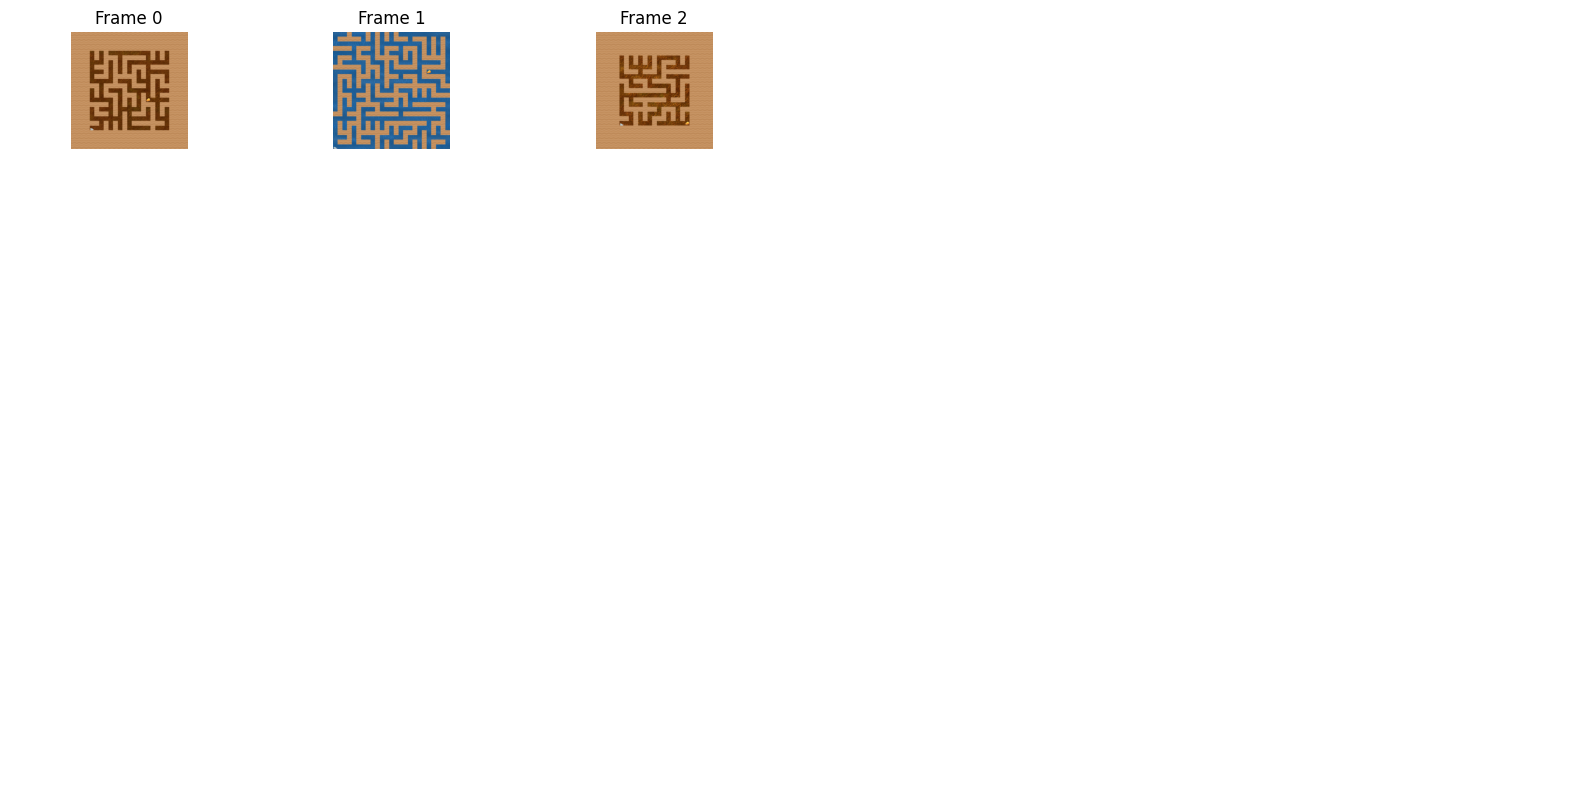

In [119]:
import matplotlib.pyplot as plt

def display_frames_grid(frames, rows=5, cols=6):
    """
    Displays frames in a grid layout.

    Args:
    - frames (list): A list of frames (images).
    - rows (int): The number of rows in the grid.
    - cols (int): The number of columns in the grid.
    """
    num_frames = rows * cols
    total_frames = len(frames)
    step = max(1, total_frames // num_frames)  # Calculate step to evenly pick frames throughout the episode
    
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10))  # Adjust figsize as needed
    fig.subplots_adjust(hspace=0.4, wspace=0.1)  # Adjust spacing as needed
    
    frame_indices = [i * step for i in range(num_frames)]
    
    for ax, frame_idx in zip(axs.flat, frame_indices):
        if frame_idx < total_frames:
            ax.imshow(frames[frame_idx])
            ax.set_title(f"Frame {frame_idx}")
        ax.axis('off')  # Hide axes for clarity
    
    plt.show()

# Example usage:
# Assuming `frames` is your list of frames captured during an episode
display_frames_grid(frames, 5, 6)

### Probe Training

We need to load the episode data, process it into a format suitable for the training process and then train [a linear probe](https://github.com/montemac/circrl/blob/33534f2f78547b38172e3a4f0d682bc8b5b46b4f/src/circrl/probing.py#L47). For this particular version we can process the episodic data into files of numpy arrays or pytorch tensors. We'll choose pytorch tensors here. 

Alternatively the data could be batched in files to reduce read/write overhead. It might be worth doing if compute bottlenecks become an obvious concern.

#### Regression Probe

Using the Ridge Regressor provided by SKLearn.

In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


def fit_linear_probe(model: Ridge, layer_name: str, inputs: np.ndarray, targets: np.ndarray, random_seed: int = 42):
    test_size = 0.2
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(
        inputs, targets, test_size=test_size, random_state=random_seed
    )

    model.fit(inputs_train, targets_train)
    return {
        "train_score": model.score(inputs_train, targets_train),
        "test_score": model.score(inputs_test, targets_test),
        "x_train": inputs_train,
        "y_train": targets_train,
        "x_test": inputs_test,
        "y_test": targets_test,
        "model": model,
    }



In [23]:
seed = 42
mdl = Ridge(random_state=seed)
layer_name = "embedder.block1.conv"
data_path = save_dir / "logs" / "ep_1.pkl"

_, _, layer_activations, cheese_positions = load_logs(data_path)
assert layer_name in layer_activations[0].keys(), "Cannot find layer '{layer_name}' in activations"

inputs = torch.stack([act[layer_name] for act in layer_activations], dim=0)
inputs = inputs.detach().numpy()
# Explicit choice to use all the activations as input instead of sampling (might need to reduce input feature space significantly to prevent overfitting)
inputs = np.reshape(inputs, (inputs.shape[0], -1))

targets = torch.tensor(cheese_positions)
targets = targets.detach().numpy()

results = fit_linear_probe(mdl, layer_name, inputs, targets, seed)
print(f"train score: {results['train_score']}")
print(f"test score: {results['test_score']}")

train score: -4.440892098500626e-16
test score: 0.0


The perfect score here is caused by the fact that the _cheese does not move_. Ergo, the probe learns to only output a single location. This should change if we train on multiple episodes.

In [68]:
def train_linear_probe(model: Ridge, layer_name: str, episode_data_dir: Path, random_seed: int = 42):
    inputs = None
    targets = None
    unique_targets = None
    train_scores = []
    test_scores = []
    
    for data_file in episode_data_dir.glob('*.pkl'):
        _, _, layer_activations, cheese_positions = load_logs(data_file)
        assert layer_name in layer_activations[0].keys(), "Cannot find layer '{layer_name}' in activations"
        
        in_tmp = torch.stack([act[layer_name] for act in layer_activations], dim=0)
        in_tmp = in_tmp.detach().numpy()
        # Explicit choice to use all the activations as input instead of sampling (might need to reduce input feature space significantly to prevent overfitting)
        in_tmp = np.reshape(in_tmp, (in_tmp.shape[0], -1))

        tar_tmp = torch.tensor(cheese_positions)
        tar_tmp = tar_tmp.detach().numpy()

        if inputs is None or targets is None:
            inputs = in_tmp
            targets = tar_tmp
        else:
            inputs = np.concatenate((inputs, in_tmp), axis=0)
            targets = np.concatenate((targets, tar_tmp), axis=0)

        if inputs.shape[0] <= 200:
            continue
        
        results = fit_linear_probe(model, layer_name, inputs, targets, seed)

        train_scores.append(results['train_score'])
        test_scores.append(results['test_score'])

        if unique_targets is None:
            unique_targets = set(tuple(item) for item in targets.tolist())
        else:
            unique_set = set(tuple(item) for item in targets)
            
            unique_targets.update(unique_set)

        unique_targets_list_of_lists = [list(item) for item in unique_targets]

        inputs = None
        targets = None

    mean_train_score = sum(train_scores)/len(train_scores)
    mean_test_score = sum(test_scores)/len(test_scores)

    print(f"mean train score: {mean_train_score}")
    print(f"mean test score: {mean_test_score}")
    print(f"number of unique targets: {len(unique_targets)}")
    return model

In [69]:
seed = 42
mdl = Ridge(random_state=seed)
layer_name = "embedder.block1.conv"
data_path = save_dir / "logs"

model = train_linear_probe(mdl, layer_name, data_path, seed)

mean train score: 0.9092914239857346
mean test score: 0.9175602310159372
number of unique targets: 51


Here we can see that there is only one target, which in hindsight makes sense because the seed is fixed. The probe only needs to learn to predict a fixed value, which is why the accuracy is 1. To 
To remediate the situation we need new data where the cheese position varies.